# VHR example
Let's use EOReader with SAR data

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   <li> We do not provide Pleiades data.
   <li> To complete this tutorial you will need <strong>matplotlib</strong>
</div>

In [1]:
import os
import glob

# First of all, we need some VHR data, let's use Pleiades data
path = os.path.abspath(glob.glob(os.path.join("/", "*", "DATA", "PRODS", "COSMO", "1011117-766193"))[0])

In [2]:
# Create logger
import logging

logger = logging.getLogger("eoreader")
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
from eoreader.reader import Reader

# Create the reader
eoreader = Reader()

In [4]:
from eoreader.bands.alias import *

# Open your product
prod = eoreader.open(path)
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

# Please be aware that EOReader will orthorectify your SAR data witn SNAP
# Be sure to have your GPT executable in your path

Acquisition datetime: 2020-10-28 22:46:25
Condensed name: 20201028T224625_CSK_HI_SCS


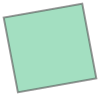

In [5]:
# Open here some more interesting geographical data: extent
extent = prod.extent()
extent.geometry.to_crs("EPSG:4326").iat[0]  # Display

2021-06-09 10:28:28,958 - eoreader - DEBUG - Pre-process SAR image


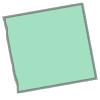

In [6]:
# Open here some more interesting geographical data: footprint
footprint = prod.footprint()
footprint.geometry.to_crs("EPSG:4326").iat[0]  # Display

For SAR data, the footprint needs the orthorectified data !
For that, SNAP uses its own DEM, but you can change it when positionning the `EOREADER_SNAP_DEM_NAME` environment variable. 
Available DEMs are:
- `ACE2_5Min` 
- `ACE30`
- `ASTER 1sec GDEM`
- `Copernicus 30m Global DEM`(buggy for now, do not use it)
- `Copernicus 90m Global DEM`(buggy for now, do not use it)
- `GETASSE30` (by default)
- `SRTM 1Sec HGT`
- `SRTM 3Sec`
- `External DEM`

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   If `External DEM` is set, you must specify the DEM you want by positioning the `EOREADER_DEM_PATH` to a DEM that can be read by SNAP.
</div>
    


In [7]:
# Set the DEM
from eoreader.env_vars import DEM_PATH
os.environ[DEM_PATH] = os.path.join("X:", "BASES_DE_DONNEES", "GLOBAL", "SRTM_30m_v4", "index.vrt")

# Select the bands you want to load
bands = [VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE]

# Be sure they exist for COSMO-SkyMed sensor:
ok_bands = [band for band in bands if prod.has_band(band)]
print(to_str(ok_bands)) # This product does not have VV band and HILLSHADE band cannot be computed from SAR band

['HH', 'HH_DSPK', 'SLOPE']


In [8]:
# Load those bands as a dict of xarray.DataArray
band_dict = prod.load(ok_bands)
band_dict[HH]

2021-06-09 10:29:52,420 - eoreader - DEBUG - Despeckling HH
2021-06-09 10:32:52,490 - eoreader - DEBUG - Warping DEM for 1011117-766193
2021-06-09 10:32:52,544 - eoreader - DEBUG - Using DEM: X:BASES_DE_DONNEES\GLOBAL\SRTM_30m_v4\index.vrt
2021-06-09 10:32:58,796 - eoreader - DEBUG - Computing slope for 1011117-766193


<xarray.DataArray '20201028T224625_CSK_HI_SCS_HH' (band: 1, y: 16228, x: 16418)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.813e+05 1.813e+05 ... 2.306e+05 2.306e+05
  * y            (y) float64 1.776e+06 1.776e+06 ... 1.727e+06 1.727e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Intensity_db_HH

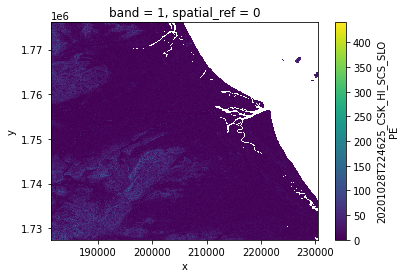

In [12]:
# Plot a subsampled version
band_dict[SLOPE][:, ::10, ::10].plot()

In [10]:
# You can also stack those bands
stack = prod.stack(ok_bands)
stack

2021-06-09 10:33:42,250 - eoreader - DEBUG - Already existing DEM for 1011117-766193. Skipping process.
2021-06-09 10:33:42,384 - eoreader - DEBUG - Already existing slope DEM for 1011117-766193. Skipping process.


<xarray.DataArray 'HH_HH_DSPK_SLOPE' (z: 3, y: 16228, x: 16418)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[13.745532, 22.274765, 21.754597, ...,       nan,       nan,
               nan],
        [21.186537, 20.42135 , 19.85021 , ...,       nan,       nan,
               nan],
        [19.413914, 18.580307, 17.949993, ...,       nan,       nan,
               nan],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,       nan,       nan,
               nan],
        [ 0.      ,  0.      ,  0.      , ...,       nan,       nan,
               nan],
        [ 0.      ,  0.      ,  0.      , ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    spatial_ref  int32 0
  * x            (x) float64 1.813e+05 1.813e+05 ... 2.306e+05 2.306e+05
  * y            (y) float64 1.776e+06 1.776e+06 ... 1.727e+06 1.727e+06
  * z            (z) MultiIndex
  - variable     (z) object 'HH' 'HH_DSPK' 'SLOPE'
  - band         (z) int64 1 1 1
Attributes:
    long_name:  ['HH', 'HH_DSPK', 'SLOPE']

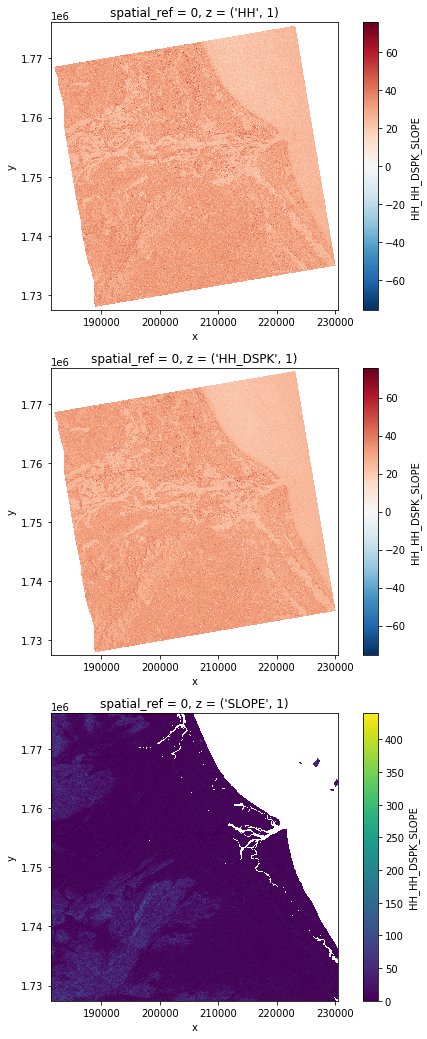

In [11]:
# Error in plotting with a list
if "long_name" in stack.attrs:
    stack.attrs.pop("long_name")

# Plot a subsampled version
import matplotlib.pyplot as plt
nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(3*nrows, 6*nrows), subplot_kw={"box_aspect": 1})
for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])